# Optical Character Recognition (OCR)

Optical Character Recognition, or OCR, is a technology that enables you to convert different types of documents, such as scanned paper documents, PDF files or images captured by a digital camera into editable and searchable data. In this section we will explore some basics of the same. MINST database (http://yann.lecun.com/exdb/mnist/) is a great dataset that is publicly available to train OCR algorithms.

What is TensorFlow ? Well at a 100K feet level it is a computational framework for distributed machine learning. Well what does that mean ? It means it is a framework that has built in efficient basic computational constructs (viz. matrix manipulation, softmax computations) and an expressive graph based descriptor language that makes it real easy to express complex machine learning algorithms. 

OCR is a problem that is particularly suited to neural networks. So let's see how we could use tensorflow to do a quick model and measure its accuracy. We will eventually use Stochastic Gradient Descent (SGD) combined with 1-hidden layer neural network with rectified linear units nn.relu()(https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Using sklearn data

First we will take a short cut and use the digits dataset that comes with scikit learn.

As a first step we want to split the data in training and test data sets. Next we reformat into a shape that's more adapted to the models we're going to train:
* data as a flat matrix,
* labels as float 1-hot encodings.

In [2]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
digits = datasets.load_digits()
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=2)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(1347, 64) (1347,) (450, 64) (450,)


In [3]:
image_size = 8
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(Xtrain, ytrain)
test_dataset, test_labels = reformat(Xtest, ytest)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (1347, 64) (1347, 10)
Test set (450, 64) (450, 10)


TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

    
    with graph.as_default():
    ...

* Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:
    
    
    with tf.Session(graph=graph) as session:
    ...
    
Let's load all the data into TensorFlow and build the computation graph corresponding to our training. We create a Placeholder node which will be fed actual data at every call of session.run().

In [4]:
batch_size = train_dataset.shape[0]
hidden_units = 1024
    
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset, dtype=tf.float32)

  # Stage 1 - Training computation.
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_units]))
  biases1 = tf.Variable(tf.zeros([hidden_units]))
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)

  # Final stage
  weights2 = tf.Variable(tf.truncated_normal([hidden_units, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(hidden1, weights2) + biases2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), 
              weights2) + biases2)

Let's run it:

In [6]:
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : train_dataset, tf_train_labels : train_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, train_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1327.455200
Minibatch accuracy: 6.8%
Minibatch loss at step 500: 0.953220
Minibatch accuracy: 59.8%
Minibatch loss at step 1000: 0.658326
Minibatch accuracy: 69.8%
Minibatch loss at step 1500: 0.605539
Minibatch accuracy: 72.2%
Minibatch loss at step 2000: 0.523631
Minibatch accuracy: 76.3%
Minibatch loss at step 2500: 0.484907
Minibatch accuracy: 77.4%
Minibatch loss at step 3000: 0.460581
Minibatch accuracy: 79.2%
Test accuracy: 76.9%


### Conclusion

As you can see the accuracy metrics are nothing to write home about. In fact they are positively dismal !! So should we stop ? Why bother learning tensorflow at all ? Well, not quite. Let's continue with OCR but with a much larger noisier data set, [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

## Using notMNIST

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [11]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labelled A through J.

In [12]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [15]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  for image_index, image in enumerate(image_files):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index + 1
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

Merge and prune data. Create validation data set. We now have training set, validation set and test set.

In [17]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. 

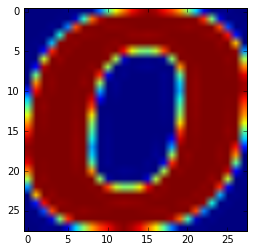

In [18]:
plt.imshow(train_dataset[10000]) # just pick one at random

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [19]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [20]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. 

In [18]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


First let's use sklearn on this data.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
lrm = LogisticRegression(penalty='l2')
data_len = 5000
Ytrain = train_labels[:data_len]
Xtrain = train_dataset[:data_len]
X2dim = Xtrain.reshape(len(Xtrain),-1)
ytest = train_labels[data_len+1:2*data_len]
Xtest = train_dataset[data_len+1:2*data_len]

In [20]:
lrm.fit(X2dim, Ytrain)
ypred= lrm.predict(Xtest.reshape(len(Xtest),-1))
print(accuracy_score(ytest, ypred))
print(confusion_matrix(ytest, ypred))

0.779155831166
[[388  12   8   5  10  13   6  23  17  12]
 [ 13 395   5  17  22  16  12  15  11  12]
 [  7   8 398   6  24   7  25   8  11   4]
 [  7  17   9 433   8   9  11  18  16  18]
 [ 12  19  40   5 360  12  18   8  33   9]
 [  6  10   8   8  17 403  11   7  18  12]
 [  7  10  24  13   9  11 352   4  17  10]
 [  8   9   4  11   8  11   6 364  19  10]
 [ 18  12  14  12  13  12  10  12 397  19]
 [  8   8  10   8  12  10   8  12  20 405]]


In [24]:
from sklearn.svm import SVC # "Support Vector Classifier"
svm = SVC(kernel='linear')
svm.fit(Xtrain, Ytrain)
ypred= svm.predict(Xtest.reshape(len(Xtest),-1))
print(accuracy_score(ytest, ypred))
print(confusion_matrix(ytest, ypred))

0.76975395079
[[401  12  11   7  11   4   4  20  13  11]
 [ 26 414   8  18  14  10   9   8   6   5]
 [  8   5 395   7  40   3  17   9   8   6]
 [ 12  35   7 427   8   6   8  15  13  15]
 [ 12  18  43   9 375  15  14   5  20   5]
 [ 10  21   8   6  19 394   9   2  19  12]
 [  9  21  41   9  19  11 318   7  18   4]
 [ 26  16   8  10   7   7   2 352  16   6]
 [ 20  19  12  12  19  13   8   9 392  15]
 [ 22  16   4  10   9  13   5  13  29 380]]


In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=999)
clf.fit(X2dim, Ytrain)
ypred = clf.predict(Xtest.reshape(len(Xtest),-1))
print(accuracy_score(ytest, ypred))
print(confusion_matrix(ytest, ypred))

0.793958791758
[[411  15   5   8   6   9   7  18   8   7]
 [ 26 414   7  16  18  11   9   4  10   3]
 [ 13  15 402   6  18   4  21   6   9   4]
 [ 11  29  12 432   7  10  14  10  11  10]
 [ 18  22  26   5 392  14  17   8  12   2]
 [  6   7   5   6  15 429   6   6  11   9]
 [ 20  31  27  14  10  11 324   5   6   9]
 [ 23  15   6   9   4  10   7 363   8   5]
 [ 13  22  10  14  16  13   8   9 399  15]
 [ 18  12   5   6   4  20   5   7  21 403]]


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [21]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (2450000, 64) (200000, 10)
Validation set (122500, 64) (10000, 10)
Test set (122500, 64) (10000, 10)


In [27]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

We now show how we could use a simple two layer NN with some tuned L2 regularization. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. With right amount of regularization we achieve about 95% accuracy !!

In [28]:
import math
batch_size = 128
beta = 0.0001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Stage 1 - Training computation.
  hidden_units1 = 512
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_units1], 
                                             stddev=math.sqrt(2.0/(image_size*image_size))))
  biases1 = tf.Variable(tf.zeros([hidden_units1]))  
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)

  hidden_units2 = 512
  weights2 = tf.Variable(tf.truncated_normal([hidden_units1, hidden_units2],
                                             stddev=math.sqrt(2.0/(hidden_units1))))
  biases2 = tf.Variable(tf.zeros([hidden_units2]))
  hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)

  # Final stage
  weights3 = tf.Variable(tf.truncated_normal([hidden_units2, num_labels],
                                            stddev=math.sqrt(2.0/(hidden_units2))))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(hidden2, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
    + (beta*(tf.nn.l2_loss(weights1) + 
             tf.nn.l2_loss(weights2) + 
             tf.nn.l2_loss(weights3))))

  # Optimizer.
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.5
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1, 0.9999)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)  
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  vp_h1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  vp_h2 = tf.nn.relu(tf.matmul(vp_h1, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(vp_h2, weights3) + biases3)
    
  test_h1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_h2 = tf.nn.relu(tf.matmul(test_h1, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(test_h2, weights3) + biases3)

In [29]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.541305
Minibatch accuracy: 8.6%
Validation accuracy: 26.3%
Minibatch loss at step 500: 0.453661
Minibatch accuracy: 85.9%
Validation accuracy: 86.5%
Minibatch loss at step 1000: 0.491737
Minibatch accuracy: 87.5%
Validation accuracy: 87.3%
Minibatch loss at step 1500: 0.345669
Minibatch accuracy: 92.2%
Validation accuracy: 88.4%
Minibatch loss at step 2000: 0.297406
Minibatch accuracy: 94.5%
Validation accuracy: 88.6%
Minibatch loss at step 2500: 0.333795
Minibatch accuracy: 92.2%
Validation accuracy: 89.2%
Minibatch loss at step 3000: 0.391534
Minibatch accuracy: 89.8%
Validation accuracy: 88.8%
Test accuracy: 95.1%
